Now that we have a single data frame with county level demographic data, we can now try to make our Machine Learning Model to predict the 2020 Presidential Results based on county demographics

In [1]:
#Load Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier



In [2]:
#Load data
df=pd.read_csv('County_Demo_Pres2020.csv')
df.head()

,Unnamed: 0,STNAME,CTYNAME,TOT_POP,PCT_MALE,PCT_FEMALE,WHITE_PCT,BLACK_PCT,HISP_PCT,OTHER_PCT,...,PCT_AGE65+,Region,PCT_COLLEGE,PCT_VOTE_BIDEN,PCT_VOTE_TRUMP,log_TOT_POP,MED_INC,PCT_UNEMPL,PCT_POVERTY,URBAN_RURAL
0,0,AL,Autauga County,55869,0.484920,0.515080,0.762623,0.201131,0.029909,0.035207,...,0.159731,SE,0.283175,0.270184,0.714368,4.747171,67565.0,0.054,0.112,3
1,1,AL,Baldwin County,223234,0.484904,0.515096,0.874410,0.087769,0.047188,0.037131,...,0.209780,SE,0.319073,0.224090,0.761714,5.348760,71135.0,0.062,0.089,4
2,2,AL,Barbour County,24686,0.529207,0.470793,0.491534,0.482298,0.045248,0.024062,...,0.196913,SE,0.116143,0.457882,0.534512,4.392451,38866.0,0.078,0.255,6
3,3,AL,Bibb County,22394,0.532687,0.467313,0.767661,0.212691,0.027820,0.018487,...,0.166696,SE,0.113467,0.206983,0.784263,4.350132,50907.0,0.073,0.178,2
4,4,AL,Blount County,57826,0.492374,0.507626,0.958254,0.016913,0.096531,0.023674,...,0.187009,SE,0.132516,0.095694,0.895716,4.762123,55203.0,0.046,0.131,2


## Feature Engineering
Lets decide which columns will be the most relevent features

Only really need one of PCT_MALE / PCT_FEMALE, because the values are related to eachother
All race data seemed relevant.
Ages15-39 and Ages65+ seemed to have an affect, whereas ages 40-65 had less of an effect on the Presidential Result
PCT_College seems to be very important as well
All these values are between 0 and 1 and do not need further preparation

The Region is a categorical value. This will need to be onehotencoded

The log Population size scaled with 2020 presidential result as well. However it will probably be best to normalize this column so the values are between 0 and 1

In [11]:
features=df[['TOT_POP','PCT_MALE','WHITE_PCT','BLACK_PCT','HISP_PCT','OTHER_PCT','PCT_AGE15_39','PCT_AGE40_65','PCT_AGE65+','PCT_COLLEGE',
             'MED_INC','PCT_UNEMPL','PCT_POVERTY','URBAN_RURAL','Region']]

In [12]:

#features=df[['PCT_MALE','WHITE_PCT','BLACK_PCT','HISP_PCT','OTHER_PCT','PCT_AGE15_39','PCT_AGE65+','PCT_COLLEGE','log_TOT_POP']]

#One Hot encode the Region Column
tempdf = pd.get_dummies(features['Region'], prefix='Region')
features = pd.merge(
    left=features,
    right=tempdf,
    left_index=True,
    right_index=True,
    )
features = features.drop(columns='Region')

features.head()

,TOT_POP,PCT_MALE,WHITE_PCT,BLACK_PCT,HISP_PCT,OTHER_PCT,PCT_AGE15_39,PCT_AGE40_65,PCT_AGE65+,PCT_COLLEGE,MED_INC,PCT_UNEMPL,PCT_POVERTY,URBAN_RURAL,Region_MW,Region_NE,Region_SE,Region_SW,Region_W
0,55869,0.484920,0.762623,0.201131,0.029909,0.035207,0.319139,0.331526,0.159731,0.283175,67565.0,0.054,0.112,3,0,0,1,0,0
1,223234,0.484904,0.874410,0.087769,0.047188,0.037131,0.281274,0.333417,0.209780,0.319073,71135.0,0.062,0.089,4,0,0,1,0,0
2,24686,0.529207,0.491534,0.482298,0.045248,0.024062,0.319533,0.313700,0.196913,0.116143,38866.0,0.078,0.255,6,0,0,1,0,0
3,22394,0.532687,0.767661,0.212691,0.027820,0.018487,0.333973,0.333527,0.166696,0.113467,50907.0,0.073,0.178,2,0,0,1,0,0
4,57826,0.492374,0.958254,0.016913,0.096531,0.023674,0.298361,0.325528,0.187009,0.132516,55203.0,0.046,0.131,2,0,0,1,0,0


In [13]:
#Normalize TOT_POP Column

features['TOT_POP']=(features['TOT_POP']-features['TOT_POP'].min())/(features['TOT_POP'].max()-features['TOT_POP'].min())
features['MED_INC']=(features['MED_INC']-features['MED_INC'].min())/(features['MED_INC'].max()-features['MED_INC'].min())
features['URBAN_RURAL']=(features['URBAN_RURAL']-features['URBAN_RURAL'].min())/(features['URBAN_RURAL'].max()-features['URBAN_RURAL'].min())

features.head()


,TOT_POP,PCT_MALE,WHITE_PCT,BLACK_PCT,HISP_PCT,OTHER_PCT,PCT_AGE15_39,PCT_AGE40_65,PCT_AGE65+,PCT_COLLEGE,MED_INC,PCT_UNEMPL,PCT_POVERTY,URBAN_RURAL,Region_MW,Region_NE,Region_SE,Region_SW,Region_W
0,0.005548,0.484920,0.762623,0.201131,0.029909,0.035207,0.319139,0.331526,0.159731,0.283175,0.325056,0.054,0.112,0.4,0,0,1,0,0
1,0.022220,0.484904,0.874410,0.087769,0.047188,0.037131,0.281274,0.333417,0.209780,0.319073,0.351038,0.062,0.089,0.6,0,0,1,0,0
2,0.002442,0.529207,0.491534,0.482298,0.045248,0.024062,0.319533,0.313700,0.196913,0.116143,0.116190,0.078,0.255,1.0,0,0,1,0,0
3,0.002214,0.532687,0.767661,0.212691,0.027820,0.018487,0.333973,0.333527,0.166696,0.113467,0.203822,0.073,0.178,0.2,0,0,1,0,0
4,0.005743,0.492374,0.958254,0.016913,0.096531,0.023674,0.298361,0.325528,0.187009,0.132516,0.235088,0.046,0.131,0.2,0,0,1,0,0


The First model we will look at is a multiple linear regression model to predict the Percentage of the Vote for Biden and Trump

In [14]:
from sklearn import linear_model
regr = linear_model.LinearRegression()

msk = np.random.rand(len(df)) < 0.8
train_x = features[msk].to_numpy()
test_x = features[~msk].to_numpy()
train_yB = df['PCT_VOTE_BIDEN'][msk].to_numpy()
test_yB = df['PCT_VOTE_BIDEN'][~msk].to_numpy()
train_yT = df['PCT_VOTE_TRUMP'][msk].to_numpy()
test_yT = df['PCT_VOTE_TRUMP'][~msk].to_numpy()



regr.fit (train_x, train_yB)
# The coefficients
print ('Coefficients: ', regr.coef_)


Coefficients:  [-1.60649231e-01 -9.65630420e-01  9.86930964e-02  7.09628801e-01
  4.04110164e-01  6.57200904e-01  1.52607668e+00  1.59938907e+00
  1.04482847e+00  6.34491236e-01 -1.24657506e-02  1.41417549e+00
  7.55069917e-03 -2.47616850e-02 -2.48105905e+12 -2.48105905e+12
 -2.48105905e+12 -2.48105905e+12 -2.48105905e+12]


Based on the Magnitudes of the coefficients, the highest correlations come from: 

-Black Population Pct

-Other Races Pct (Native Am, Asian, 2or More Races)


In [15]:
from sklearn.metrics import r2_score

y_hat= regr.predict(test_x)
print("Residual sum of squares: %.4f"
      % np.mean((y_hat - test_yB) ** 2))

# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % r2_score(test_yB,y_hat))


Residual sum of squares: 0.0054
R2 score: 0.75


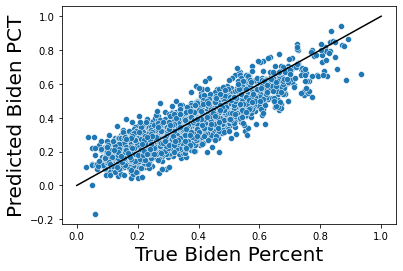

In [16]:
#

df['MLR Prediction']=regr.predict(features.to_numpy())
x=np.linspace(0,1,100)
sns.scatterplot(y='MLR Prediction',x='PCT_VOTE_BIDEN', data=df)
plt.xlabel("True Biden Percent",fontsize=20)
plt.ylabel("Predicted Biden PCT",fontsize=20)
plt.plot(x,x,'k')
plt.show()

#### Pretty low sum of squares, but the R2 value is pretty low. Only 75% of the data is accurately predicted by the model

Lets Try to simplify the model to just predict weather or not Biden or Trump won the county (margin doesn't Matter). 

We will create an new column 'County Result' that is equal to 1 if Biden won more votes than Trump, and 0 if Trump got more Votes than Biden

In [20]:



df['County Result'].value_counts()

0    2548
1     476
Name: County Result, dtype: int64

From This We see that trump won 2553 Counties and Biden won 481

In [21]:

#For the Features we will Use the Standard Scalar to transform the data for Machine Learning

transform = preprocessing.StandardScaler()
X= transform.fit(features).transform(features)


#Get Biden Percentage
Y=df['County Result'].to_numpy()


#Split intro training data and test data
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2)


In [22]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs','newton-cg','liblinear']}

lr=LogisticRegression()
grid_search = GridSearchCV(lr, parameters, cv=10)
logreg_cv = grid_search.fit(X_train, Y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.9425379788073112


In [23]:
logreg_cv.score(X_test, Y_test)

0.943801652892562

The model correctly guesses 93.3% of the test data, which is pretty good!

In [24]:
#Lets create a confusion matrix function to help evaluate the model

def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Trump Win', 'Biden Win']); ax.yaxis.set_ticklabels(['Trump Win', 'Biden Win'])

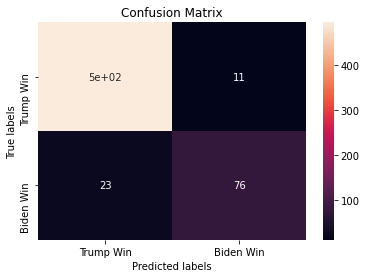

In [25]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

### Scalar Vector Machine

Lets test the SVM algorithm

In [26]:
parameters = {'kernel':['linear'],
              'C': np.logspace(-2, 2, 3),
              'gamma':np.logspace(-2, 2, 3)}
svm = SVC()

In [27]:
grid_searchSVM = GridSearchCV(svm, parameters, cv=10,n_jobs=-1)
svm_cv = grid_searchSVM.fit(X_train, Y_train)
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.01, 'kernel': 'linear'}
accuracy : 0.9437810774664792


In [28]:
svm_cv.score(X_test, Y_test)

0.9404958677685951

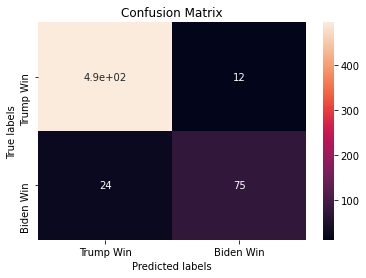

In [29]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

### Decision Tree

In [30]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [31]:
grid_searchDT = GridSearchCV(tree, parameters, cv=10)
tree_cv = grid_searchDT.fit(X_train, Y_train)

In [32]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'best'}
accuracy : 0.9181578135180549


In [33]:
tree_cv.score(X_test, Y_test)

0.9305785123966942

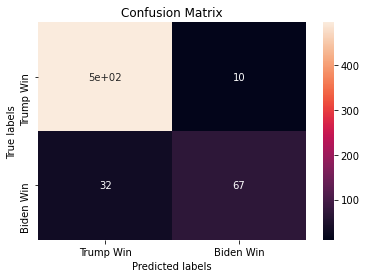

In [34]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

### K Nearest Neighbors

In [36]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [37]:
grid_searchKNN = GridSearchCV(KNN, parameters, cv=10)
knn_cv = grid_searchKNN.fit(X_train, Y_train)


In [38]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1}
accuracy : 0.9317993210109392


In [39]:
knn_cv.score(X_test, Y_test)

0.943801652892562

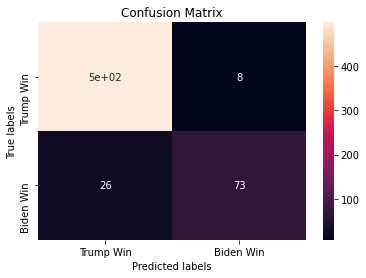

In [40]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

In [43]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

f1_score(Y_test,yhat)


0.8111111111111111

In [44]:
jaccard_score(Y_test,yhat)

0.6822429906542056

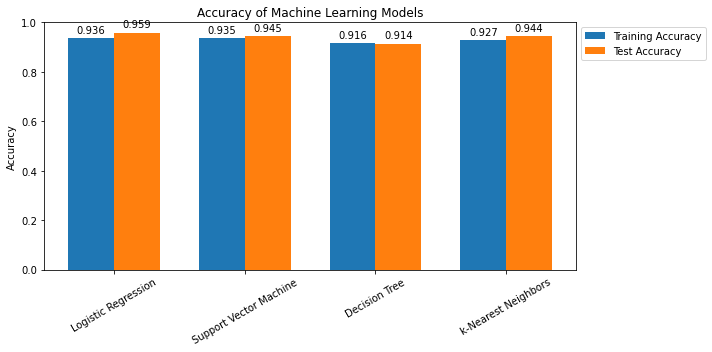

In [111]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['Logistic Regression', 'Support Vector Machine', 'Decision Tree', 'k-Nearest Neighbors']


train_acc=[logreg_cv.best_score_,svm_cv.best_score_,tree_cv.best_score_,knn_cv.best_score_]
test_acc=[logreg_cv.score(X_test, Y_test),svm_cv.score(X_test, Y_test),tree_cv.score(X_test, Y_test),knn_cv.score(X_test, Y_test)]

train_acc=np.around(train_acc,decimals=3)
test_acc=np.around(test_acc,decimals=3)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))

rects1 = ax.bar(x - width/2, train_acc, width, label='Training Accuracy')
rects2 = ax.bar(x + width/2, test_acc, width, label='Test Accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of Machine Learning Models')
ax.set_xticks(x, labels,rotation=30)
ax.legend( bbox_to_anchor=(1,1))

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.set_ylim(ymax=1)
fig.tight_layout()

plt.show()

In [112]:
df['Log Prediction']=logreg_cv.predict(X)


def f2(row):
    if row['Log Prediction'] == row['County Result']:
        val = 1
    else:
        val = 0
    return val

df['County Prediction'] = df.apply(f2, axis=1)


df['County Prediction'].value_counts()

1    2847
0     177
Name: County Prediction, dtype: int64

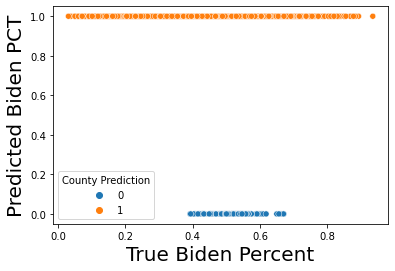

In [113]:


sns.scatterplot(y='County Prediction',x='PCT_VOTE_BIDEN', hue='County Prediction',data=df)
plt.xlabel("True Biden Percent",fontsize=20)
plt.ylabel("Predicted Biden PCT",fontsize=20)
#plt.plot(x,x,'k')
plt.show()

In [114]:
df_wrong=df[df['County Prediction']==0]

df_wrong.describe()

,Unnamed: 0,TOT_POP,PCT_MALE,PCT_FEMALE,WHITE_PCT,BLACK_PCT,HISP_PCT,OTHER_PCT,PCT_AGE15_39,PCT_AGE40_65,...,PCT_VOTE_TRUMP,log_TOT_POP,MED_INC,PCT_UNEMPL,PCT_POVERTY,URBAN_RURAL,MLR Prediction,County Result,Log Prediction,County Prediction
count,177.000000,1.770000e+02,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,...,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.0
mean,1580.169492,1.562084e+05,0.497999,0.502001,0.769341,0.147145,0.158998,0.082121,0.325722,0.312614,...,0.467063,4.784946,61477.723164,0.076751,0.139034,4.107345,0.454841,0.706215,0.293785,0.0
std,940.658156,2.281647e+05,0.019805,0.019805,0.179348,0.177105,0.206328,0.092776,0.054635,0.034967,...,0.059697,0.656436,17659.268795,0.021734,0.062581,1.498030,0.068325,0.456787,0.456787,0.0
min,44.000000,7.280000e+02,0.459771,0.371648,0.305807,0.000808,0.014378,0.013001,0.214661,0.168298,...,0.302139,2.862131,28004.000000,0.041000,0.030000,1.000000,0.227539,0.000000,0.000000,0.0
25%,744.000000,2.154700e+04,0.487258,0.496749,0.633585,0.015546,0.039377,0.039354,0.294704,0.292204,...,0.431274,4.333387,48864.000000,0.062000,0.093000,3.000000,0.415283,0.000000,0.000000,0.0
50%,1721.000000,6.438600e+04,0.494989,0.505011,0.844721,0.061282,0.070639,0.058689,0.319316,0.317916,...,0.463129,4.808791,58445.000000,0.074000,0.125000,4.000000,0.456055,1.000000,0.000000,0.0
75%,2440.000000,1.976920e+05,0.503251,0.512742,0.909802,0.248610,0.177326,0.091693,0.348491,0.332454,...,0.502924,5.295989,68744.000000,0.086000,0.186000,5.000000,0.505859,1.000000,1.000000,0.0
max,2985.000000,1.476601e+06,0.628352,0.540229,0.971154,0.601888,0.927115,0.649926,0.506149,0.457152,...,0.589260,6.169263,122290.000000,0.169000,0.368000,6.000000,0.635254,1.000000,1.000000,0.0


In [115]:
df.describe()

,Unnamed: 0,TOT_POP,PCT_MALE,PCT_FEMALE,WHITE_PCT,BLACK_PCT,HISP_PCT,OTHER_PCT,PCT_AGE15_39,PCT_AGE40_65,...,PCT_VOTE_TRUMP,log_TOT_POP,MED_INC,PCT_UNEMPL,PCT_POVERTY,URBAN_RURAL,MLR Prediction,County Result,Log Prediction,County Prediction
count,3024.000000,3.024000e+03,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,...,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000
mean,1511.500000,1.015222e+05,0.501027,0.498973,0.845891,0.095473,0.098907,0.057401,0.302480,0.317752,...,0.654412,4.453829,56975.953042,0.066968,0.138428,4.644511,0.326094,0.157407,0.133267,0.941468
std,873.097933,3.340550e+05,0.022303,0.022303,0.159226,0.145778,0.140117,0.078516,0.047970,0.026448,...,0.156243,0.642608,14281.154350,0.022851,0.054253,1.502985,0.136683,0.364245,0.339919,0.234785
min,0.000000,1.690000e+02,0.429918,0.265138,0.053537,0.000000,0.006478,0.004518,0.130154,0.139085,...,0.087300,2.227887,22901.000000,0.015000,0.030000,1.000000,-0.072998,0.000000,0.000000,0.000000
25%,755.750000,1.080300e+04,0.489774,0.494121,0.796692,0.008936,0.024886,0.025797,0.272892,0.304604,...,0.566867,4.033544,47555.500000,0.052000,0.100000,3.000000,0.229187,0.000000,0.000000,1.000000
50%,1511.500000,2.527500e+04,0.497143,0.502857,0.912809,0.026568,0.045298,0.036451,0.297417,0.320070,...,0.686925,4.402691,54848.500000,0.065000,0.129000,5.000000,0.294189,0.000000,0.000000,1.000000
75%,2267.250000,6.670000e+04,0.505879,0.510226,0.954130,0.112491,0.102370,0.057447,0.324754,0.334351,...,0.773564,4.824126,63424.750000,0.080000,0.167000,6.000000,0.400940,0.000000,0.000000,1.000000
max,3023.000000,1.003911e+07,0.734862,0.570082,0.990350,0.865932,0.963533,0.941737,0.605849,0.457152,...,0.961818,7.001695,160305.000000,0.228000,0.439000,6.000000,0.922852,1.000000,1.000000,1.000000


Our big issue is that we have an imbalanced classification, There are way more Trump won counties than Biden won counties. Let's try to fix that

In [116]:
!pip install imbalanced-learn

In [46]:
from imblearn.over_sampling import SMOTE
# transform the dataset
oversample = SMOTE()
X2, y2 = oversample.fit_resample(X, Y)


In [47]:


#Split intro training data and test data
X_train2, X_test2, Y_train2, Y_test2 = train_test_split( X2, y2, test_size=0.2)


In [119]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs','newton-cg','liblinear']}

lr=LogisticRegression()
grid_search = GridSearchCV(lr, parameters, cv=10)
logreg_cv = grid_search.fit(X_train2, Y_train2)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy : 0.9232060268824975


In [120]:
logreg_cv.score(X_test2, Y_test2)


0.9225490196078432

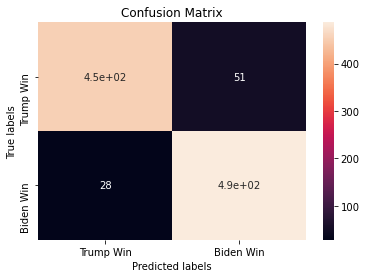

In [121]:
yhat=logreg_cv.predict(X_test2)
plot_confusion_matrix(Y_test2,yhat)

In [122]:
parameters = {'kernel':['linear'],
              'C': np.logspace(-2, 2, 3),
              'gamma':np.logspace(-2, 2, 3)}
svm = SVC()

In [123]:
grid_searchSVM = GridSearchCV(svm, parameters, cv=10,n_jobs=-1)
svm_cv = grid_searchSVM.fit(X_train2, Y_train2)
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 100.0, 'gamma': 0.01, 'kernel': 'linear'}
accuracy : 0.9278659006600183


In [124]:
svm_cv.score(X_test2, Y_test2)


0.9235294117647059

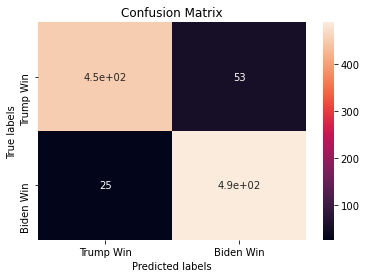

In [125]:
yhat=svm_cv.predict(X_test2)
plot_confusion_matrix(Y_test2,yhat)

In [126]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [127]:
grid_searchDT = GridSearchCV(tree, parameters, cv=10)
tree_cv = grid_searchDT.fit(X_train2, Y_train2)

In [128]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
accuracy : 0.9290913908560968


In [129]:
tree_cv.score(X_test2, Y_test2)


0.9215686274509803

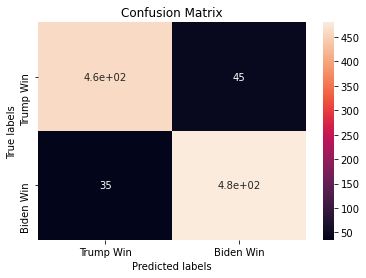

In [130]:
yhat = tree_cv.predict(X_test2)
plot_confusion_matrix(Y_test2,yhat)

In [48]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [49]:
grid_searchKNN = GridSearchCV(KNN, parameters, cv=10)
knn_cv = grid_searchKNN.fit(X_train2, Y_train2)


In [50]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 1, 'p': 1}
accuracy : 0.9631955484896662


In [51]:
knn_cv.score(X_test2, Y_test2)


0.9676470588235294

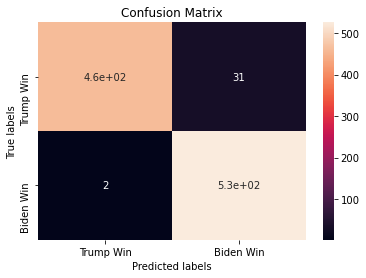

In [52]:
yhat = knn_cv.predict(X_test2)
plot_confusion_matrix(Y_test2,yhat)

In [53]:
f1_score(Y_test2,yhat)

0.9695852534562212

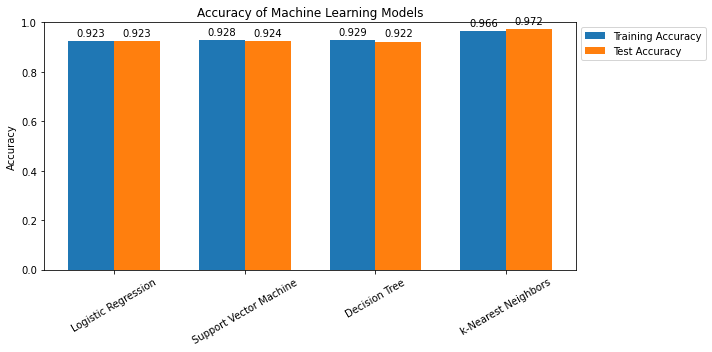

In [136]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['Logistic Regression', 'Support Vector Machine', 'Decision Tree', 'k-Nearest Neighbors']


train_acc=[logreg_cv.best_score_,svm_cv.best_score_,tree_cv.best_score_,knn_cv.best_score_]
test_acc=[logreg_cv.score(X_test2, Y_test2),svm_cv.score(X_test2, Y_test2),tree_cv.score(X_test2, Y_test2),knn_cv.score(X_test2, Y_test2)]

train_acc=np.around(train_acc,decimals=3)
test_acc=np.around(test_acc,decimals=3)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))

rects1 = ax.bar(x - width/2, train_acc, width, label='Training Accuracy')
rects2 = ax.bar(x + width/2, test_acc, width, label='Test Accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of Machine Learning Models')
ax.set_xticks(x, labels,rotation=30)
ax.legend( bbox_to_anchor=(1,1))

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.set_ylim(ymax=1)
fig.tight_layout()

plt.show()

In [54]:
df['KNN Prediction']=knn_cv.predict(X)


def f2(row):
    if row['KNN Prediction'] == row['County Result']:
        val = 1
    else:
        val = 0
    return val

df['County Prediction'] = df.apply(f2, axis=1)


df['County Prediction'].value_counts()

1    2992
0      32
Name: County Prediction, dtype: int64

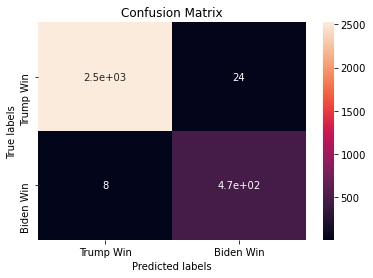

In [138]:
plot_confusion_matrix(df['County Result'],df['KNN Prediction'])

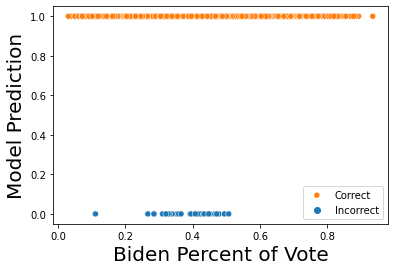

In [68]:
l={0:'incorrect',1:'correct'}

sns.scatterplot(y='County Prediction',x='PCT_VOTE_BIDEN', hue='County Prediction',data=df)

plt.xlabel("Biden Percent of Vote",fontsize=20)
plt.ylabel("Model Prediction",fontsize=20)
plt.legend(labels=['Correct', 'Incorrect'])

#plt.plot(x,x,'k')
plt.show()

In [140]:
df[df['County Result']==0].describe()

,Unnamed: 0,TOT_POP,PCT_MALE,PCT_FEMALE,WHITE_PCT,BLACK_PCT,HISP_PCT,OTHER_PCT,PCT_AGE15_39,PCT_AGE40_65,...,log_TOT_POP,MED_INC,PCT_UNEMPL,PCT_POVERTY,URBAN_RURAL,MLR Prediction,County Result,Log Prediction,County Prediction,KNN Prediction
count,2548.000000,2.548000e+03,2548.000000,2548.000000,2548.000000,2548.000000,2548.000000,2548.000000,2548.000000,2548.000000,...,2548.000000,2548.000000,2548.000000,2548.000000,2548.000000,2548.000000,2548.0,2548.000000,2548.000000,2548.000000
mean,1523.131083,5.049091e+04,0.502319,0.497681,0.879476,0.070421,0.088289,0.049052,0.295240,0.319522,...,4.351145,55946.460754,0.063977,0.135454,4.839874,0.284280,0.0,0.020408,0.990581,0.009419
std,858.601403,9.115713e+04,0.021908,0.021908,0.114566,0.104035,0.123903,0.057850,0.041998,0.024773,...,0.556530,12143.570080,0.021103,0.048288,1.377745,0.093111,0.0,0.141420,0.096613,0.096613
min,0.000000,1.690000e+02,0.429918,0.265138,0.301762,0.000000,0.006478,0.004518,0.130154,0.139085,...,2.227887,25997.000000,0.015000,0.030000,1.000000,-0.072998,0.0,0.000000,0.000000,0.000000
25%,789.500000,9.917750e+03,0.490962,0.493107,0.848465,0.008231,0.023840,0.025185,0.269876,0.306610,...,3.996413,47806.750000,0.050000,0.100000,4.000000,0.219421,0.0,0.000000,1.000000,0.000000
50%,1512.000000,2.215350e+04,0.497962,0.502038,0.926193,0.021278,0.041114,0.034324,0.292074,0.321642,...,4.345442,54279.000000,0.062000,0.128000,5.000000,0.273193,0.0,0.000000,1.000000,0.000000
75%,2280.250000,4.989975e+04,0.506893,0.509038,0.958203,0.078088,0.089646,0.049630,0.315177,0.335461,...,4.698098,62086.250000,0.077000,0.163000,6.000000,0.344482,0.0,0.000000,1.000000,0.000000
max,3023.000000,1.476601e+06,0.734862,0.570082,0.990350,0.518251,0.947105,0.692609,0.605849,0.429398,...,6.169263,122290.000000,0.169000,0.382000,6.000000,0.635254,0.0,1.000000,1.000000,1.000000


In [141]:

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import manifold

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [142]:
x_train=np.copy(X_train)
x_test=np.copy(X_test)

x_train /= 255
x_test /= 255

print(x_trainD.shape[0], 'train samples')
print(x_testD.shape[0], 'test samples')

print(x_trainD.shape[1], 'train features')
print(x_testD.shape[1], 'test features')

batch_size = 32
num_classes = 2
epochs = 400



# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(Y_train, num_classes)
y_test = keras.utils.to_categorical(Y_test, num_classes)

model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(18,)))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

2419 train samples
605 test samples
18 train features
18 test features
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 16)                304       
_________________________________________________________________
dropout_15 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_16 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 34        
Total params: 610
Trainable params: 610
Non-trainable params: 0
_________________________________________________________________


In [143]:
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K

K.set_session(tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)))

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/400
76/76 [==============================] - 0s 2ms/step - loss: 0.5909 - accuracy: 0.8322 - val_loss: 0.4849 - val_accuracy: 0.8612
Epoch 2/400
76/76 [==============================] - 0s 961us/step - loss: 0.4642 - accuracy: 0.8379 - val_loss: 0.4084 - val_accuracy: 0.8612
Epoch 3/400
76/76 [==============================] - 0s 961us/step - loss: 0.4399 - accuracy: 0.8379 - val_loss: 0.3920 - val_accuracy: 0.8612
Epoch 4/400
76/76 [==============================] - 0s 997us/step - loss: 0.4333 - accuracy: 0.8379 - val_loss: 0.3839 - val_accuracy: 0.8612
Epoch 5/400
76/76 [==============================] - 0s 976us/step - loss: 0.4267 - accuracy: 0.8379 - val_loss: 0.3781 - val_accuracy: 0.8612
Epoch 6/400
76/76 [==============================] - 0s 966us/step - loss: 0.4176 - accuracy: 0.8379 - val_loss: 0.3672 - val_accuracy: 0.8612
Epoch 7/400
76/76 [==============================] - 0s 999us/step - loss: 0.4046 - accuracy: 0.8379 - val_loss: 0.3543 - val_accuracy: 0.8612
E

76/76 [==============================] - 0s 1ms/step - loss: 0.1806 - accuracy: 0.9334 - val_loss: 0.1404 - val_accuracy: 0.9438
Epoch 59/400
76/76 [==============================] - 0s 1ms/step - loss: 0.1773 - accuracy: 0.9347 - val_loss: 0.1490 - val_accuracy: 0.9438
Epoch 60/400
76/76 [==============================] - 0s 1000us/step - loss: 0.1738 - accuracy: 0.9310 - val_loss: 0.1379 - val_accuracy: 0.9388
Epoch 61/400
76/76 [==============================] - 0s 966us/step - loss: 0.1754 - accuracy: 0.9351 - val_loss: 0.1380 - val_accuracy: 0.9405
Epoch 62/400
76/76 [==============================] - 0s 953us/step - loss: 0.1768 - accuracy: 0.9285 - val_loss: 0.1454 - val_accuracy: 0.9372
Epoch 63/400
76/76 [==============================] - 0s 986us/step - loss: 0.1785 - accuracy: 0.9277 - val_loss: 0.1390 - val_accuracy: 0.9421
Epoch 64/400
76/76 [==============================] - 0s 934us/step - loss: 0.1798 - accuracy: 0.9318 - val_loss: 0.1375 - val_accuracy: 0.9421
Epoch 65

Epoch 115/400
76/76 [==============================] - 0s 974us/step - loss: 0.1661 - accuracy: 0.9301 - val_loss: 0.1282 - val_accuracy: 0.9537
Epoch 116/400
76/76 [==============================] - 0s 1ms/step - loss: 0.1613 - accuracy: 0.9326 - val_loss: 0.1295 - val_accuracy: 0.9521
Epoch 117/400
76/76 [==============================] - 0s 974us/step - loss: 0.1594 - accuracy: 0.9334 - val_loss: 0.1263 - val_accuracy: 0.9537
Epoch 118/400
76/76 [==============================] - 0s 960us/step - loss: 0.1654 - accuracy: 0.9339 - val_loss: 0.1265 - val_accuracy: 0.9504
Epoch 119/400
76/76 [==============================] - 0s 1ms/step - loss: 0.1638 - accuracy: 0.9363 - val_loss: 0.1287 - val_accuracy: 0.9521
Epoch 120/400
76/76 [==============================] - 0s 961us/step - loss: 0.1621 - accuracy: 0.9359 - val_loss: 0.1265 - val_accuracy: 0.9488
Epoch 121/400
76/76 [==============================] - 0s 960us/step - loss: 0.1603 - accuracy: 0.9351 - val_loss: 0.1264 - val_accura

Epoch 172/400
76/76 [==============================] - 0s 1ms/step - loss: 0.1532 - accuracy: 0.9368 - val_loss: 0.1221 - val_accuracy: 0.9504
Epoch 173/400
76/76 [==============================] - 0s 934us/step - loss: 0.1568 - accuracy: 0.9380 - val_loss: 0.1264 - val_accuracy: 0.9388
Epoch 174/400
76/76 [==============================] - 0s 987us/step - loss: 0.1573 - accuracy: 0.9347 - val_loss: 0.1196 - val_accuracy: 0.9438
Epoch 175/400
76/76 [==============================] - 0s 987us/step - loss: 0.1576 - accuracy: 0.9368 - val_loss: 0.1283 - val_accuracy: 0.9471
Epoch 176/400
76/76 [==============================] - 0s 947us/step - loss: 0.1517 - accuracy: 0.9380 - val_loss: 0.1231 - val_accuracy: 0.9471
Epoch 177/400
76/76 [==============================] - 0s 1ms/step - loss: 0.1588 - accuracy: 0.9372 - val_loss: 0.1225 - val_accuracy: 0.9471
Epoch 178/400
76/76 [==============================] - 0s 973us/step - loss: 0.1557 - accuracy: 0.9380 - val_loss: 0.1188 - val_accura

Epoch 229/400
76/76 [==============================] - 0s 1ms/step - loss: 0.1555 - accuracy: 0.9372 - val_loss: 0.1170 - val_accuracy: 0.9521
Epoch 230/400
76/76 [==============================] - 0s 1ms/step - loss: 0.1525 - accuracy: 0.9392 - val_loss: 0.1205 - val_accuracy: 0.9471
Epoch 231/400
76/76 [==============================] - 0s 1ms/step - loss: 0.1592 - accuracy: 0.9363 - val_loss: 0.1257 - val_accuracy: 0.9438
Epoch 232/400
76/76 [==============================] - 0s 1ms/step - loss: 0.1542 - accuracy: 0.9392 - val_loss: 0.1291 - val_accuracy: 0.9455
Epoch 233/400
76/76 [==============================] - 0s 1ms/step - loss: 0.1540 - accuracy: 0.9347 - val_loss: 0.1203 - val_accuracy: 0.9504
Epoch 234/400
76/76 [==============================] - 0s 1ms/step - loss: 0.1568 - accuracy: 0.9380 - val_loss: 0.1227 - val_accuracy: 0.9471
Epoch 235/400
76/76 [==============================] - 0s 1ms/step - loss: 0.1543 - accuracy: 0.9355 - val_loss: 0.1194 - val_accuracy: 0.9488

Epoch 286/400
76/76 [==============================] - 0s 1ms/step - loss: 0.1489 - accuracy: 0.9463 - val_loss: 0.1198 - val_accuracy: 0.9521
Epoch 287/400
76/76 [==============================] - 0s 974us/step - loss: 0.1492 - accuracy: 0.9372 - val_loss: 0.1246 - val_accuracy: 0.9537
Epoch 288/400
76/76 [==============================] - 0s 1000us/step - loss: 0.1492 - accuracy: 0.9434 - val_loss: 0.1156 - val_accuracy: 0.9570
Epoch 289/400
76/76 [==============================] - 0s 974us/step - loss: 0.1520 - accuracy: 0.9392 - val_loss: 0.1213 - val_accuracy: 0.9537
Epoch 290/400
76/76 [==============================] - 0s 947us/step - loss: 0.1532 - accuracy: 0.9368 - val_loss: 0.1258 - val_accuracy: 0.9388
Epoch 291/400
76/76 [==============================] - 0s 987us/step - loss: 0.1498 - accuracy: 0.9430 - val_loss: 0.1186 - val_accuracy: 0.9554
Epoch 292/400
76/76 [==============================] - 0s 960us/step - loss: 0.1453 - accuracy: 0.9430 - val_loss: 0.1195 - val_acc

Epoch 399/400
76/76 [==============================] - 0s 1ms/step - loss: 0.1416 - accuracy: 0.9454 - val_loss: 0.1137 - val_accuracy: 0.9537
Epoch 400/400
76/76 [==============================] - 0s 974us/step - loss: 0.1427 - accuracy: 0.9421 - val_loss: 0.1161 - val_accuracy: 0.9488
Test loss: 0.11614660173654556
Test accuracy: 0.9487603306770325


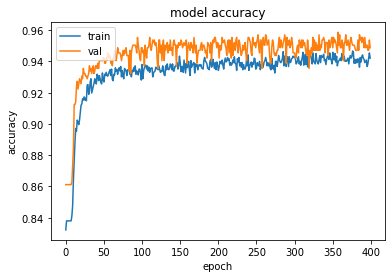

In [144]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

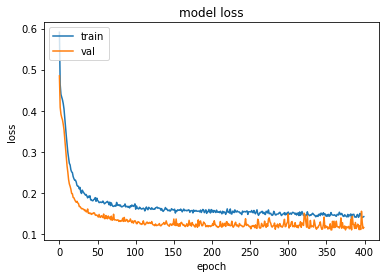

In [145]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()